somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
setup -t b1813 ip_diffim
setup -k -r .
scons
```
now edit and run the code in here.

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import numpy as np

import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

np.random.seed(666)

In [3]:
## Code updated from lsstsw/build/ip_diffim/tests/dipole.py

## Old code used a double gaussian psf which has the problem that it is pixel-oriented.
## Let's use afwMath.DoubleGaussianFunction2D() instead...
## Change parameterization to pixels - separation (in pixels) and psfWidth (pixels)

## Weird behavior, this fails the dipole lobes are not offset from each other in y direction (hence the +0.05 below...)

def createDipole(w=100, h=100, xc=50., yc=50., separation=2.4, scaling = 100.0, psfWidth=2.0, display=False):  ## fracOffset = 1.2, psfSize=17, 
    # Make random noise image: set image plane to normal distribution
    image = afwImage.MaskedImageF(w,h)
    image.set(0)
    array = image.getImage().getArray()
    array[:,:] = np.random.randn(w,h)
    # Set variance to 1.0 -- update, should set variance after adding flux
    var   = image.getVariance()
    var.set(1.0)
        
    # Create Psf for dipole creation and measurement. Need a psf object too (for source detection below)
    psfSize = int(psfWidth * 20.) + 1
    psf = measAlg.DoubleGaussianPsf(psfSize, psfSize, psfWidth, psfWidth*1.75, 0.1) ## 2.0, 3.5, 0.1)
    generator = afwMath.DoubleGaussianFunction2D(psfWidth, psfWidth*1.75, 0.1)    

    psfim = psf.computeImage().convertF()
    psfim *= scaling / psf.computePeak()
    psfw, psfh = psfim.getDimensions()
    psfSum = np.sum(psfim.getArray())

    if display:
        #ds9.mtv(image, frame=1, title="Original image")
        #ds9.mtv(image.getVariance(), frame=2, title="Original variance")
        psf_arr = psf.computeImage().convertF().getArray()
        plt.imshow(np.rot90(psf_arr), cmap='gray', extent=(0,psfSize-1,0,psfSize-1), interpolation='none')
        plt.plot(psfw//2, psfw//2, 'bo')
        plt.title("PSF")
        plt.show()

    # Create the dipole separated by pixels instead of the old fracOffset of Psf FWHM
    array  = image.getImage().getArray()
    xp, yp = xc - separation/2., yc #- 0.05 #separation/2. ##xc - psfw//2 + offset, yc - psfh//2 + offset
    imPos = np.ndarray( (w,h), buffer=np.array([ generator(i-xp,j-yp) for i in xrange(w) for j in xrange(h) ]) )
    array[:] += imPos/np.max(imPos)*scaling
    psfSum = np.sum(imPos/np.max(imPos)*scaling) # get more accurate input "flux"

    xn, yn = xc + separation/2., yc #+ 0.05 #separation/2. ##xn, yn = xc - psfw//2 - offset, yc - psfh//2 - offset
    imPos = np.ndarray( (w,h), buffer=np.array([ generator(i-xn,j-yn) for i in xrange(w) for j in xrange(h) ]) )
    array[:] -= imPos/np.max(imPos)*scaling
    
    print xp, yp
    print xn, yn
    dipoleCenters = {'pos': (xp, yp), 'neg':(xn, yn)}

    # Create an exposure, detect positive and negative peaks separately
    # Need to create a psf object anyway, so that's why we did it above, same parameters as the function.
    
    exp = afwImage.makeExposure(image)
    exp.setPsf(psf)

    if display:
        #ds9.mtv(image, frame=3, title="With dipole")
        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Original image with dipole")
        plt.imshow(np.rot90(img_arr), vmin=-scaling, vmax=scaling, cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.plot(xp, yp, 'bx')
        plt.plot(xn, yn, 'bx')
        ##plt.show()
    
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = True
    schema = afwTable.SourceTable.makeMinimalSchema()
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exp)
#     if display:
#         ds9.mtv(image, frame=4, title="Detection plane")
        
    # Merge them together
    assert(len(results.sources) == 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, 1, 1, False) ## note used to be tGrow=0, rGrow=0, but sometimes sources were not merged.
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    assert(len(sources) == 1)
    s = sources[0]
    assert(len(s.getFootprint().getPeaks()) == 2)

    if display:
        ## first overlay the fp centers on the input image and show it.
        for pk in s.getFootprint().getPeaks():
            print pk.getIy(), pk.getIx()
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()
        
        img_arr, mask_arr, var_arr = exp.getMaskedImage().getArrays()
        plt.title("Detection plane")
        plt.imshow(np.rot90(mask_arr), vmin=-100, vmax=100, cmap='gray', extent=(0,99,0,99), interpolation='none')
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIy(), pk.getIx(), 'rx')
        plt.show()
        
    return psf, psfSum, exp, s, dipoleCenters

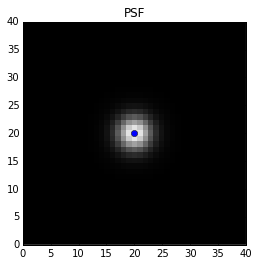

48.8 50
51.2 50
47 50
53 50


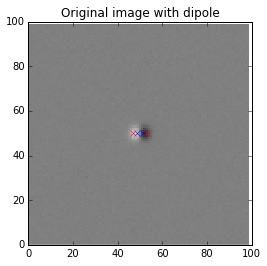

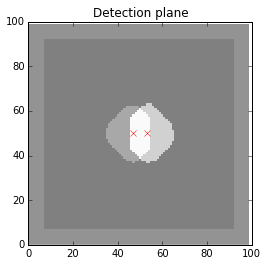

2998.55348293 {'neg': (51.2, 50), 'pos': (48.8, 50)}


In [4]:
w, h = 100, 100 # size of image
xc, yc = 50, 50 # location of center of dipole
separation = 2.4
psf, psfSum, exposure, s, dipoleCenters = createDipole(w, h, xc, yc, separation=separation, display=True)
print psfSum, dipoleCenters

In [5]:
## I think this is the meat of the code that runs the measurement. How do I get the complete set of (fitted) parameters out? 
## THat is the question!
## OK, figured it out, see below...
def measureDipole(s, exp):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", xc)
    source.set("centroid_y", yc)
    source.setFootprint(s.getFootprint())

    print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exp)
    return measCat  ##[0] 

In [6]:
#print 'DIPOLE: ' + s.get(dipoleFlag)
sources = measureDipole(s, exposure) ## OK, this just returns the input coords but should set a dipole flag if it fits to a dipole
print 'DIPOLE: ', sources[0].get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
source = sources[0]
fp     = source.getFootprint()
peaks  = fp.getPeaks()
speaks = [(p.getPeakValue(), p) for p in peaks]
speaks.sort()
dpeaks = [speaks[0][1], speaks[-1][1]]
print dpeaks
##print source.schema
print source.getCentroid() ## This just returns the values set in the "source.set("centroid_x", xc), ..." lines... ??
print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
print source.get("ip_diffim_PsfDipoleFlux_pos_flux"), source.get("ip_diffim_PsfDipoleFlux_neg_flux")

DIPOLE:  nan
DIPOLE:  1.0
[2: (50,53)  (50.000,53.000), 1: (50,47)  (50.000,47.000)]
(50, 50)
50.008808136 47.1697044373 49.9934577942 52.819442749
50.0075509054 48.8050569885 50.0017368924 51.184609386
3028.95736254 -3030.94119367


In [7]:
## provides (S/N, position, orientation) of measured dipoles
dpAnalysis = ipDiffim.DipoleAnalysis()
sn, centroid, orientation = dpAnalysis(source)
print sn, centroid, orientation

60.4238122554 (50.005, 49.995) 3.13915 rad


In [8]:
## deblend a source as a dipole, and return a new source with deblended footprints.
dpDeblender = ipDiffim.DipoleDeblender()
deblendedSource = dpDeblender(source, exposure)
print deblendedSource.getCentroid()
print deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_pos_y"), \
    deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_x"), deblendedSource.get("ip_diffim_NaiveDipoleCentroid_neg_y")
print deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"), \
    deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
print deblendedSource.get("ip_diffim_PsfDipoleFlux_pos_flux"), deblendedSource.get("ip_diffim_PsfDipoleFlux_neg_flux")

(50, 50)
50.008808136 47.1697044373 49.9934577942 52.819442749
50.0075509054 48.8050569885 50.0017368924 51.184609386
3028.95736254 -3030.94119367


In [9]:
# Recreate the simultaneous joint Psf fit in python
## This just fits for the flux of the dipole lobes, given a pair of input centroids.
def _makeModel(exposure, psf, fp, negCenter, posCenter, display=False):
    negPsf = psf.computeImage(negCenter).convertF()
    posPsf = psf.computeImage(posCenter).convertF()
    negPeak = psf.computePeak(negCenter)
    posPeak = psf.computePeak(posCenter)
    negPsf /= negPeak
    posPsf /= posPeak

    model    = afwImage.ImageF(fp.getBBox())
    negModel = afwImage.ImageF(fp.getBBox())
    posModel = afwImage.ImageF(fp.getBBox())

    # The center of the Psf should be at negCenter, posCenter
    negPsfBBox = negPsf.getBBox()
    posPsfBBox = posPsf.getBBox()
    modelBBox  = model.getBBox()

    # Portion of the negative Psf that overlaps the montage
    negOverlapBBox = afwGeom.Box2I(negPsfBBox)
    negOverlapBBox.clip(modelBBox)
    #self.assertFalse(negOverlapBBox.isEmpty())

    # Portion of the positivePsf that overlaps the montage
    posOverlapBBox = afwGeom.Box2I(posPsfBBox)
    posOverlapBBox.clip(modelBBox)
    #self.assertFalse(posOverlapBBox.isEmpty())

    negPsfSubim    = type(negPsf)(negPsf, negOverlapBBox)
    modelSubim     = type(model)(model, negOverlapBBox)
    negModelSubim  = type(negModel)(negModel, negOverlapBBox)
    modelSubim    += negPsfSubim  # just for debugging
    negModelSubim += negPsfSubim  # for fitting

    posPsfSubim    = type(posPsf)(posPsf, posOverlapBBox)
    modelSubim     = type(model)(model, posOverlapBBox)
    posModelSubim  = type(posModel)(posModel, posOverlapBBox)
    modelSubim    += posPsfSubim
    posModelSubim += posPsfSubim

    data = afwImage.ImageF(exposure.getMaskedImage().getImage(), fp.getBBox())
    var = afwImage.ImageF(exposure.getMaskedImage().getVariance(), fp.getBBox())
    matrixNorm = 1. / np.sqrt(np.median(var.getArray()))

    posPsfSum = np.sum(posPsf.getArray())
    negPsfSum = np.sum(negPsf.getArray())

    M = np.array((np.ravel(negModel.getArray()), np.ravel(posModel.getArray()))).T.astype(np.float64)
    B = np.array((np.ravel(data.getArray()))).astype(np.float64)
    M *= matrixNorm
    B *= matrixNorm

    # Numpy solution
    fneg0, fpos0 = np.linalg.lstsq(M, B)[0]

    # Afw solution
    lsq = afwMath.LeastSquares.fromDesignMatrix(M, B, afwMath.LeastSquares.DIRECT_SVD)
    fneg, fpos = lsq.getSolution()

    # Should be exaxtly the same as each other
    #self.assertAlmostEqual(1e-2*fneg0,  1e-2*fneg)
    #self.assertAlmostEqual(1e-2*fpos0,  1e-2*fpos)

    # Recreate model
    fitted  = afwImage.ImageF(fp.getBBox())
    negFit  = type(negPsf)(negPsf, negOverlapBBox, afwImage.PARENT, True)
    negFit *= float(fneg)
    posFit  = type(posPsf)(posPsf, posOverlapBBox, afwImage.PARENT, True)
    posFit *= float(fpos)

    fitSubim  = type(fitted)(fitted, negOverlapBBox)
    fitSubim += negFit
    fitSubim  = type(fitted)(fitted, posOverlapBBox)
    fitSubim += posFit
    
    if display:
    #    ds9.mtv(model, frame=5, title="Unfitted model")
    #    ds9.mtv(data, frame=6, title="Data")
        fig = plt.figure()
        a = fig.add_subplot(1,3,1)
        plt.imshow(np.rot90(model.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Unfitted model (footprint?)')
        #plt.show()
        a = fig.add_subplot(1,3,2)
        plt.imshow(np.rot90(data.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Data')
        #plt.show()

    #if display:
    #    ds9.mtv(fitted, frame=7, title="Fitted model")
        a = fig.add_subplot(1,3,3)
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Fitted model')
        plt.show()

    fitted   -= data

    if display:
    #    ds9.mtv(fitted, frame=8, title="Residuals")
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Residuals')
        plt.show()

    fitted   *= fitted
    fitted   /= var

    if display:
    #    ds9.mtv(fitted, frame=9, title="Chi2")
        plt.imshow(np.rot90(fitted.getArray()), cmap='gray', extent=(0,99,0,99), interpolation='none')
        plt.title('Chi2')
        plt.show()

    return fneg, negPsfSum, fpos, posPsfSum, fitted

(50, 47) (50, 53)


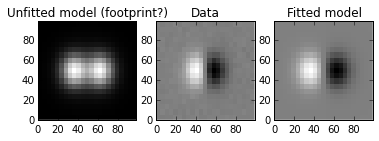

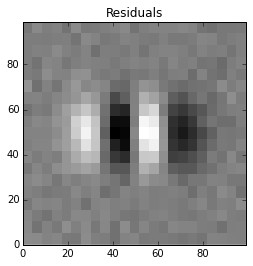

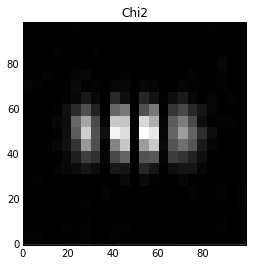

0.532784361312 0.531943900164


In [10]:
negCenter = afwGeom.Point2D(dpeaks[0].getFx(), dpeaks[0].getFy())
posCenter = afwGeom.Point2D(dpeaks[1].getFx(), dpeaks[1].getFy())
print posCenter, negCenter

fneg, negPsfSum, fpos, posPsfSum, residIm = _makeModel(exposure, psf, fp, negCenter, posCenter, display=True)

# Should be close to the same as the inputs; as fracOffset
# gets smaller this will be worse.
print -1e-2*fneg,  1e-2*fpos

## Looks like ACB's test code uses the integral value for the naive dipole fitted peak centroid...?

(50.008, 48.805) (50.002, 51.185)


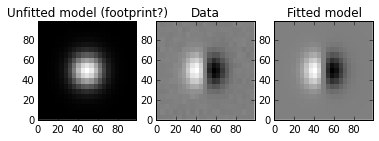

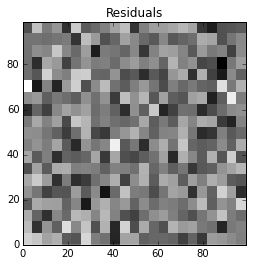

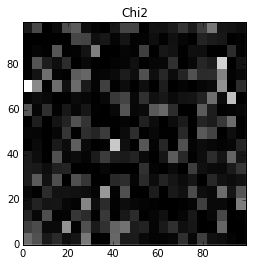

1.01555886996 1.01489274819


In [11]:
negCenter = afwGeom.Point2D(source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"))
posCenter = afwGeom.Point2D(source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"))
print posCenter, negCenter

fneg, negPsfSum, fpos, posPsfSum, residIm = _makeModel(exposure, psf, fp, negCenter, posCenter, display=True)

# Should be close to the same as the inputs
print -1e-2*fneg,  1e-2*fpos